In [11]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Utils.functions import *

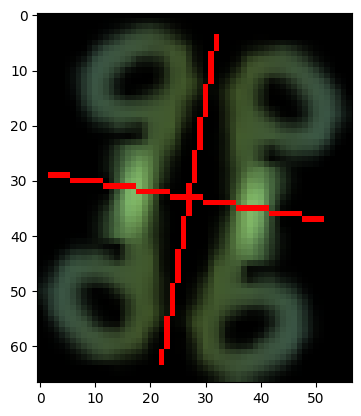

In [12]:
# Draws all lines in list on specified color
def drawLines(img: np.ndarray, lines: list, color: list[int] = [255,0, 0]):
    for [startAxis, endAxis] in lines:
        cv2.line(img, (int(startAxis[0]) , int(startAxis[1])), (int(endAxis[0]) , int(endAxis[1])), color, 1)
    return img

mnist = pd.read_csv('MNIST/mnist_test.csv')
img, dict = createAnySymmetry(random.randint(0,10000), mnist, ['simple', 'cross'], [0.5, 0.5])

drawLines(img, dict['symAxes'])
plt.imshow(img)

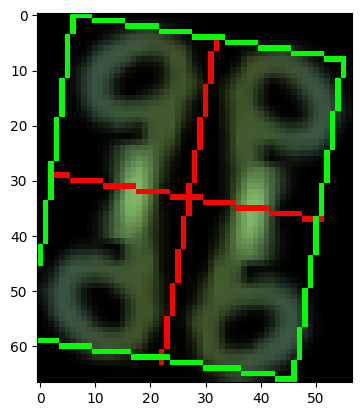

In [28]:
# Draws polygon on the image
def drawPolygon(img: np.ndarray, points: list, color: list[int] = [0, 255, 0]):
    for i in range(len(points)):
        if i != len(points)-1:
            cv2.line(img, (int(points[i][0]),int(points[i][1])), (int(points[i+1][0]),int(points[i+1][1])), color, 1)
        else:    
            cv2.line(img, (int(points[i][0]),int(points[i][1])), (int(points[0][0]),int(points[0][1])), color, 1)

# Returns bounding box points given parameters
def getBoundingBoxPoints(center: list, width: int, height: int, rotation: float):
    # Points for bounding box
    pts = [(center[0]-width/2 , center[1]-height/2), (center[0]+width/2 , center[1]-height/2), 
           (center[0]+width/2 , center[1]+height/2), (center[0]-width/2 , center[1]+height/2)]
    
    # Rotating
    rotationMatrix = cv2.getRotationMatrix2D(center, rotation, 1)
    return transformKeypoints(pts, rotationMatrix)

pts = getBoundingBoxPoints(dict['center'], dict['width'], dict['height'], dict['finalRotation'])

disp = img.copy()
drawPolygon(disp, pts)
plt.imshow(disp)

In [14]:
# Draws off dictionary
def drawFromDictionary(img, dict):
    pass # DO THIS ONE AT SOME POINT I'D SAY
